# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [1]:
%pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [3]:
!pip install kaggle

In [4]:
import os

using_colab = True  # False if using JupyterLab
##### COLAB #####
if using_colab:
    from google.colab import files
    files.upload()  # upload kaggle.json
    !chmod 600 /content/kaggle.json

    os.environ['KAGGLE_CONFIG_DIR'] = '/content'

### JUPYTERLAB ###
else:
    from pathlib import Path
    # upload kaggle.json!!!
    kaggle_dir = Path.home() / ".kaggle"
    kaggle_dir.mkdir(exist_ok=True)
    Path("kaggle.json").replace(kaggle_dir / "kaggle.json")
    os.chmod(kaggle_dir / "kaggle.json", 0o600)

    os.environ['KAGGLE_CONFIG_DIR'] = str(kaggle_dir)

Saving kaggle.json to kaggle.json


In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

!kaggle competitions download -c cse-251-b-2025

 98% 986M/0.98G [00:04<00:00, 208MB/s]
100% 0.98G/0.98G [00:04<00:00, 225MB/s]


In [6]:
# Load in data files
# Unzip data
import zipfile

if using_colab:
    zip_path = '/content/cse-251-b-2025.zip'
    extract_to = '/content/data'
else:
    zip_path = Path("cse-251-b-2025.zip")
    extract_to = Path("data")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

train_file = np.load('/content/data/train.npz')
test_file = np.load('/content/data/test_input.npz')

train_data = train_file['data']
test_data = test_file['data']

print("(scenes, trajectories, time steps, dimensions)")
print(f"train data shape: {train_data.shape}")
print(f"test data shape:  {test_data.shape}")

(scenes, trajectories, time steps, dimensions)
train data shape: (10000, 50, 110, 6)
test data shape:  (2100, 50, 50, 6)


In [ ]:
# train_npz = np.load('./train.npz')
# train_data = train_npz['data']
# test_npz  = np.load('./test_input.npz')
# test_data  = test_npz['data']

In [7]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [ ]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [ ]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

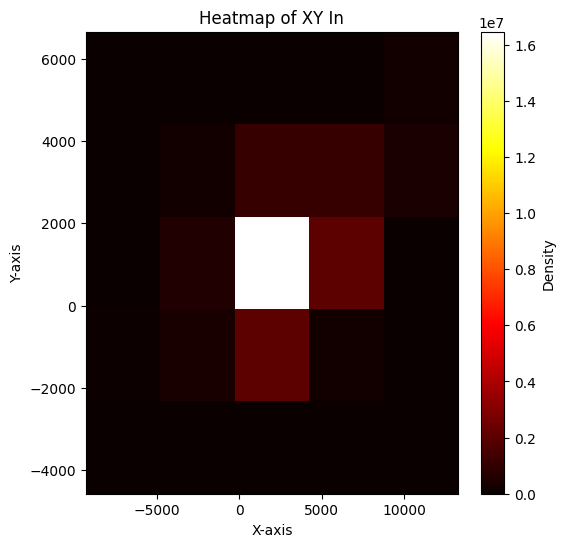

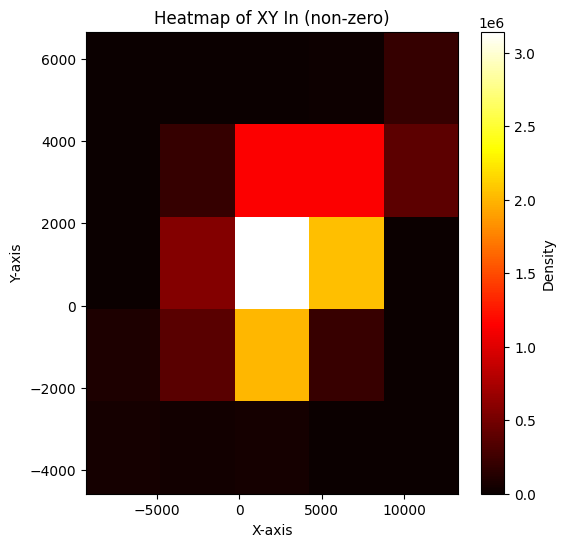

In [ ]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

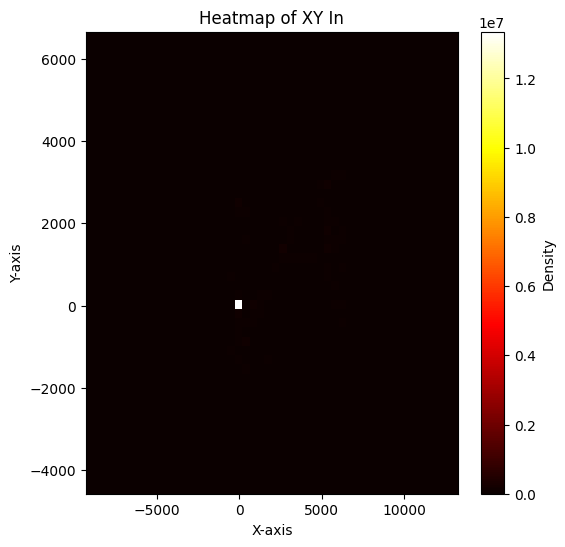

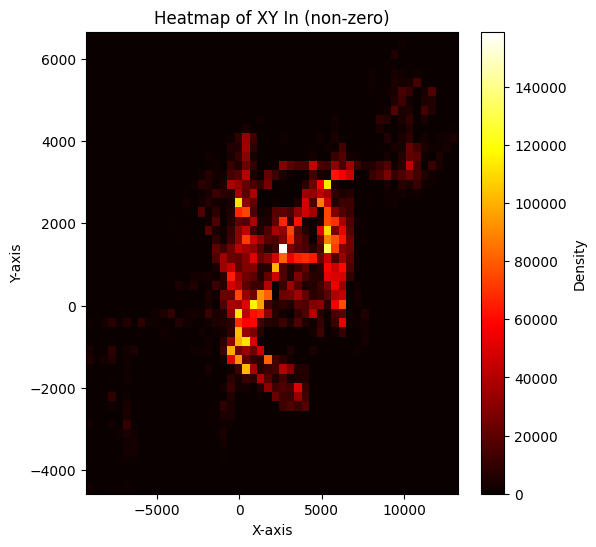

In [ ]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [8]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      scene = self.data[idx]  # (50 agents, 110 timesteps, 6 features)
      hist = scene[:, :50, :].copy()    # (50, 50, 6)
      future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)

      # Data augmentation
      if self.augment:
          if np.random.rand() < 0.5:
              theta = np.random.uniform(-np.pi, np.pi)
              R = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
              hist[..., :2] = hist[..., :2] @ R
              hist[..., 2:4] = hist[..., 2:4] @ R
              future = future @ R
          if np.random.rand() < 0.5:
              hist[..., 0] *= -1
              hist[..., 2] *= -1
              future[:, 0] *= -1

      # Use the last timeframe of the ego as the origin
      ego_final = hist[0, 49, :2].copy()  # (2,)
      hist[..., :2] -= ego_final
      future -= ego_final

      # Find distances from all agents to the ego at t=49
      all_final_positions = hist[:, 49, :2]  # (50, 2)
      dists = np.linalg.norm(all_final_positions, axis=1)  # (50,)
      dists[0] = -1e6  # Always include ego (set to negative so it's ranked first)

      # Get indices of ego + 10 nearest neighbors (total 11 agents)
      selected_indices = np.argsort(dists)[:7]  # Shape: (11,)

      # Select only those 11 agents
      hist = hist[selected_indices, :, :]  # (11, 50, 6)

      # Normalize
      hist[..., :4] /= self.scale
      future /= self.scale

      return Data(
          x=torch.tensor(hist, dtype=torch.float32),
          y=future.type(torch.float32),
          origin=torch.tensor(ego_final, dtype=torch.float32).unsqueeze(0),
          scale=torch.tensor(self.scale, dtype=torch.float32),
      )



class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      scene = self.data[idx]  # (50, 50, 6)
      hist = scene.copy()

      ego_final = hist[0, 49, :2].copy()
      hist[..., :2] -= ego_final

      # Select closest 10 + ego
      all_final_positions = hist[:, 49, :2]
      dists = np.linalg.norm(all_final_positions, axis=1)
      dists[0] = -1e6  # Ensure ego is included
      selected_indices = np.argsort(dists)[:7]
      hist = hist[selected_indices, :, :]  # (11, 50, 6)
      print(f"hist shape in __getitem__: {hist.shape}")


      hist[..., :4] /= self.scale

      return Data(
          x=torch.tensor(hist, dtype=torch.float32),
          origin=torch.tensor(ego_final, dtype=torch.float32).unsqueeze(0),
          scale=torch.tensor(self.scale, dtype=torch.float32),
      )


#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [9]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()

        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(256, output_features)
        )

    def forward(self, data):
        x = data.x
        x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [11]:
# class LSTM(nn.Module):
#     def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
#         super(LSTM, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, data):
#         x = data.x
#         # x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
#         # x = x[:, 0, :, :] # Only Consider ego agent index 0
#         x = data.x.reshape(-1, 11, 50, 6)  # (batch, 11 agents, 50 timesteps, 6)

#         # If only using ego:
#         x = x[:, 0, :, :]  # (batch, 50, 6)


#         lstm_out, _ = self.lstm(x)
#         # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
#         out = self.fc(lstm_out[:, -1, :])
#         return out.view(-1, 60, 2)

class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.agent_pool = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x  # (batch_size, 7, 50, 6)
        x = x.reshape(-1, 50, 6)  # (batch_size * 7, 50, 6)

        lstm_out, _ = self.lstm(x)  # (B*7, 50, hidden)
        last_hidden = lstm_out[:, -1, :]  # (B*7, hidden)
        last_hidden = last_hidden.view(-1, 7, last_hidden.size(-1))  # (B, 7, hidden)

        # Aggregate agent features via mean/max pooling or MLP
        pooled = last_hidden.mean(dim=1)  # (B, hidden) – or use attention later
        pooled = self.agent_pool(pooled)

        out = self.fc(pooled)  # (B, 60*2)
        return out.view(-1, 60, 2)


#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [12]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTM().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
early_stopping_patience = 10
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [13]:
for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    scheduler.step()
    # scheduler.step(val_loss)

    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]<ipython-input-8-4219dd54706e>:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
<ipython-input-8-4219dd54706e>:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future -= ego_final
Epoch:   1%|          | 1/100 [00:10<17:39, 10.70s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   4.1234 | val normalized MSE   1.4484, | val MAE   5.0510 | val MSE  70.9737


Epoch:   2%|▏         | 2/100 [00:18<15:08,  9.27s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   1.0067 | val normalized MSE   0.7336, | val MAE   3.4120 | val MSE  35.9446


Epoch:   3%|▎         | 3/100 [00:26<13:55,  8.61s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.6239 | val normalized MSE   0.5606, | val MAE   3.0003 | val MSE  27.4697


Epoch:   4%|▍         | 4/100 [00:35<13:38,  8.52s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.4581 | val normalized MSE   0.4707, | val MAE   2.8054 | val MSE  23.0625


Epoch:   5%|▌         | 5/100 [00:43<13:24,  8.47s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.3989 | val normalized MSE   0.3593, | val MAE   2.3431 | val MSE  17.6039


Epoch:   6%|▌         | 6/100 [00:51<12:56,  8.26s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.3666 | val normalized MSE   0.3328, | val MAE   2.2368 | val MSE  16.3066


Epoch:   7%|▋         | 7/100 [00:59<12:51,  8.30s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.3604 | val normalized MSE   0.3499, | val MAE   2.2950 | val MSE  17.1446


Epoch:   8%|▊         | 8/100 [01:08<12:55,  8.43s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.3553 | val normalized MSE   0.3845, | val MAE   2.6322 | val MSE  18.8391


Epoch:   9%|▉         | 9/100 [01:16<12:46,  8.43s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.3393 | val normalized MSE   0.3128, | val MAE   2.1193 | val MSE  15.3274


Epoch:  10%|█         | 10/100 [01:25<12:33,  8.37s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.3254 | val normalized MSE   0.2985, | val MAE   2.1578 | val MSE  14.6243


Epoch:  11%|█         | 11/100 [01:33<12:24,  8.36s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.3230 | val normalized MSE   0.2620, | val MAE   1.9111 | val MSE  12.8402


Epoch:  12%|█▏        | 12/100 [01:41<12:05,  8.25s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.3152 | val normalized MSE   0.2894, | val MAE   2.0752 | val MSE  14.1801


Epoch:  13%|█▎        | 13/100 [01:49<11:57,  8.24s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.3083 | val normalized MSE   0.2910, | val MAE   2.1110 | val MSE  14.2577


Epoch:  14%|█▍        | 14/100 [01:58<11:52,  8.29s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.3116 | val normalized MSE   0.2777, | val MAE   2.0308 | val MSE  13.6074


Epoch:  15%|█▌        | 15/100 [02:06<11:38,  8.22s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.3069 | val normalized MSE   0.3181, | val MAE   2.1913 | val MSE  15.5870


Epoch:  16%|█▌        | 16/100 [02:14<11:29,  8.21s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.3048 | val normalized MSE   0.3202, | val MAE   2.1994 | val MSE  15.6877


Epoch:  17%|█▋        | 17/100 [02:22<11:26,  8.27s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2941 | val normalized MSE   0.2685, | val MAE   2.0330 | val MSE  13.1576


Epoch:  18%|█▊        | 18/100 [02:30<11:14,  8.23s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2981 | val normalized MSE   0.2914, | val MAE   2.2407 | val MSE  14.2761


Epoch:  19%|█▉        | 19/100 [02:39<11:03,  8.20s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2911 | val normalized MSE   0.3591, | val MAE   2.3760 | val MSE  17.5970


Epoch:  20%|██        | 20/100 [02:47<10:59,  8.24s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.3041 | val normalized MSE   0.2916, | val MAE   2.0339 | val MSE  14.2901


Epoch:  21%|██        | 21/100 [02:55<10:49,  8.22s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2462 | val normalized MSE   0.2227, | val MAE   1.6788 | val MSE  10.9137


Epoch:  22%|██▏       | 22/100 [03:03<10:40,  8.21s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2365 | val normalized MSE   0.2365, | val MAE   1.7866 | val MSE  11.5897


Epoch:  23%|██▎       | 23/100 [03:12<10:37,  8.27s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2343 | val normalized MSE   0.2219, | val MAE   1.6941 | val MSE  10.8744


Epoch:  24%|██▍       | 24/100 [03:20<10:30,  8.29s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2351 | val normalized MSE   0.2197, | val MAE   1.6790 | val MSE  10.7663


Epoch:  25%|██▌       | 25/100 [03:28<10:19,  8.26s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2320 | val normalized MSE   0.2247, | val MAE   1.7300 | val MSE  11.0101


Epoch:  26%|██▌       | 26/100 [03:37<10:13,  8.29s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.2322 | val normalized MSE   0.2219, | val MAE   1.6575 | val MSE  10.8746


Epoch:  27%|██▋       | 27/100 [03:45<10:05,  8.29s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.2279 | val normalized MSE   0.2182, | val MAE   1.6974 | val MSE  10.6938


Epoch:  28%|██▊       | 28/100 [03:53<09:47,  8.16s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.2298 | val normalized MSE   0.2281, | val MAE   1.7147 | val MSE  11.1781


Epoch:  29%|██▉       | 29/100 [04:01<09:42,  8.21s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.2324 | val normalized MSE   0.2225, | val MAE   1.6978 | val MSE  10.9045


Epoch:  30%|███       | 30/100 [04:09<09:36,  8.24s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.2290 | val normalized MSE   0.2268, | val MAE   1.7284 | val MSE  11.1118


Epoch:  31%|███       | 31/100 [04:17<09:19,  8.10s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.2319 | val normalized MSE   0.2203, | val MAE   1.7323 | val MSE  10.7944


Epoch:  32%|███▏      | 32/100 [04:25<09:14,  8.15s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.2295 | val normalized MSE   0.2276, | val MAE   1.6981 | val MSE  11.1544


Epoch:  33%|███▎      | 33/100 [04:34<09:08,  8.18s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.2270 | val normalized MSE   0.2163, | val MAE   1.6550 | val MSE  10.5996


Epoch:  34%|███▍      | 34/100 [04:41<08:51,  8.05s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.2264 | val normalized MSE   0.2479, | val MAE   1.8622 | val MSE  12.1449


Epoch:  35%|███▌      | 35/100 [04:50<08:45,  8.09s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.2249 | val normalized MSE   0.2142, | val MAE   1.6992 | val MSE  10.4961


Epoch:  36%|███▌      | 36/100 [04:58<08:40,  8.13s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.2259 | val normalized MSE   0.2229, | val MAE   1.7548 | val MSE  10.9211


Epoch:  37%|███▋      | 37/100 [05:05<08:24,  8.01s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.2255 | val normalized MSE   0.2177, | val MAE   1.7194 | val MSE  10.6676


Epoch:  38%|███▊      | 38/100 [05:14<08:18,  8.04s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.2268 | val normalized MSE   0.2125, | val MAE   1.6499 | val MSE  10.4105


Epoch:  39%|███▉      | 39/100 [05:22<08:14,  8.10s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.2247 | val normalized MSE   0.2121, | val MAE   1.6882 | val MSE  10.3930


Epoch:  40%|████      | 40/100 [05:30<07:59,  8.00s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.2265 | val normalized MSE   0.2179, | val MAE   1.6932 | val MSE  10.6795


Epoch:  41%|████      | 41/100 [05:38<07:55,  8.06s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.2122 | val normalized MSE   0.2065, | val MAE   1.5975 | val MSE  10.1190


Epoch:  42%|████▏     | 42/100 [05:46<07:52,  8.14s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.2086 | val normalized MSE   0.2051, | val MAE   1.5756 | val MSE  10.0514


Epoch:  43%|████▎     | 43/100 [05:54<07:37,  8.02s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.2080 | val normalized MSE   0.2036, | val MAE   1.5657 | val MSE   9.9762


Epoch:  44%|████▍     | 44/100 [06:02<07:32,  8.07s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.2077 | val normalized MSE   0.2038, | val MAE   1.5688 | val MSE   9.9849


Epoch:  45%|████▌     | 45/100 [06:10<07:26,  8.12s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.2081 | val normalized MSE   0.2086, | val MAE   1.6091 | val MSE  10.2198


Epoch:  46%|████▌     | 46/100 [06:18<07:13,  8.02s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.2073 | val normalized MSE   0.2024, | val MAE   1.5717 | val MSE   9.9198


Epoch:  47%|████▋     | 47/100 [06:26<07:09,  8.10s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.2071 | val normalized MSE   0.1975, | val MAE   1.5534 | val MSE   9.6751


Epoch:  48%|████▊     | 48/100 [06:35<07:03,  8.15s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.2070 | val normalized MSE   0.2057, | val MAE   1.6196 | val MSE  10.0814


Epoch:  49%|████▉     | 49/100 [06:43<06:51,  8.06s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.2068 | val normalized MSE   0.1991, | val MAE   1.5625 | val MSE   9.7554


Epoch:  50%|█████     | 50/100 [06:51<06:46,  8.13s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.2065 | val normalized MSE   0.2041, | val MAE   1.5557 | val MSE  10.0008


Epoch:  51%|█████     | 51/100 [06:59<06:39,  8.16s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.2060 | val normalized MSE   0.2006, | val MAE   1.5768 | val MSE   9.8293


Epoch:  52%|█████▏    | 52/100 [07:07<06:26,  8.06s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.2058 | val normalized MSE   0.2013, | val MAE   1.6084 | val MSE   9.8639


Epoch:  53%|█████▎    | 53/100 [07:15<06:21,  8.12s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.2053 | val normalized MSE   0.1978, | val MAE   1.5407 | val MSE   9.6905


Epoch:  54%|█████▍    | 54/100 [07:23<06:15,  8.16s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.2059 | val normalized MSE   0.2045, | val MAE   1.5780 | val MSE  10.0227


Epoch:  55%|█████▌    | 55/100 [07:31<06:03,  8.07s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.2061 | val normalized MSE   0.1997, | val MAE   1.5705 | val MSE   9.7838


Epoch:  56%|█████▌    | 56/100 [07:39<05:56,  8.11s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.2066 | val normalized MSE   0.1997, | val MAE   1.5810 | val MSE   9.7846


Epoch:  56%|█████▌    | 56/100 [07:48<06:07,  8.36s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.2047 | val normalized MSE   0.1994, | val MAE   1.5448 | val MSE   9.7721
Early stop!


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [14]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')

    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')

    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

    if title:
        ax.set_title(title)

    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

<ipython-input-8-4219dd54706e>:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future -= ego_final


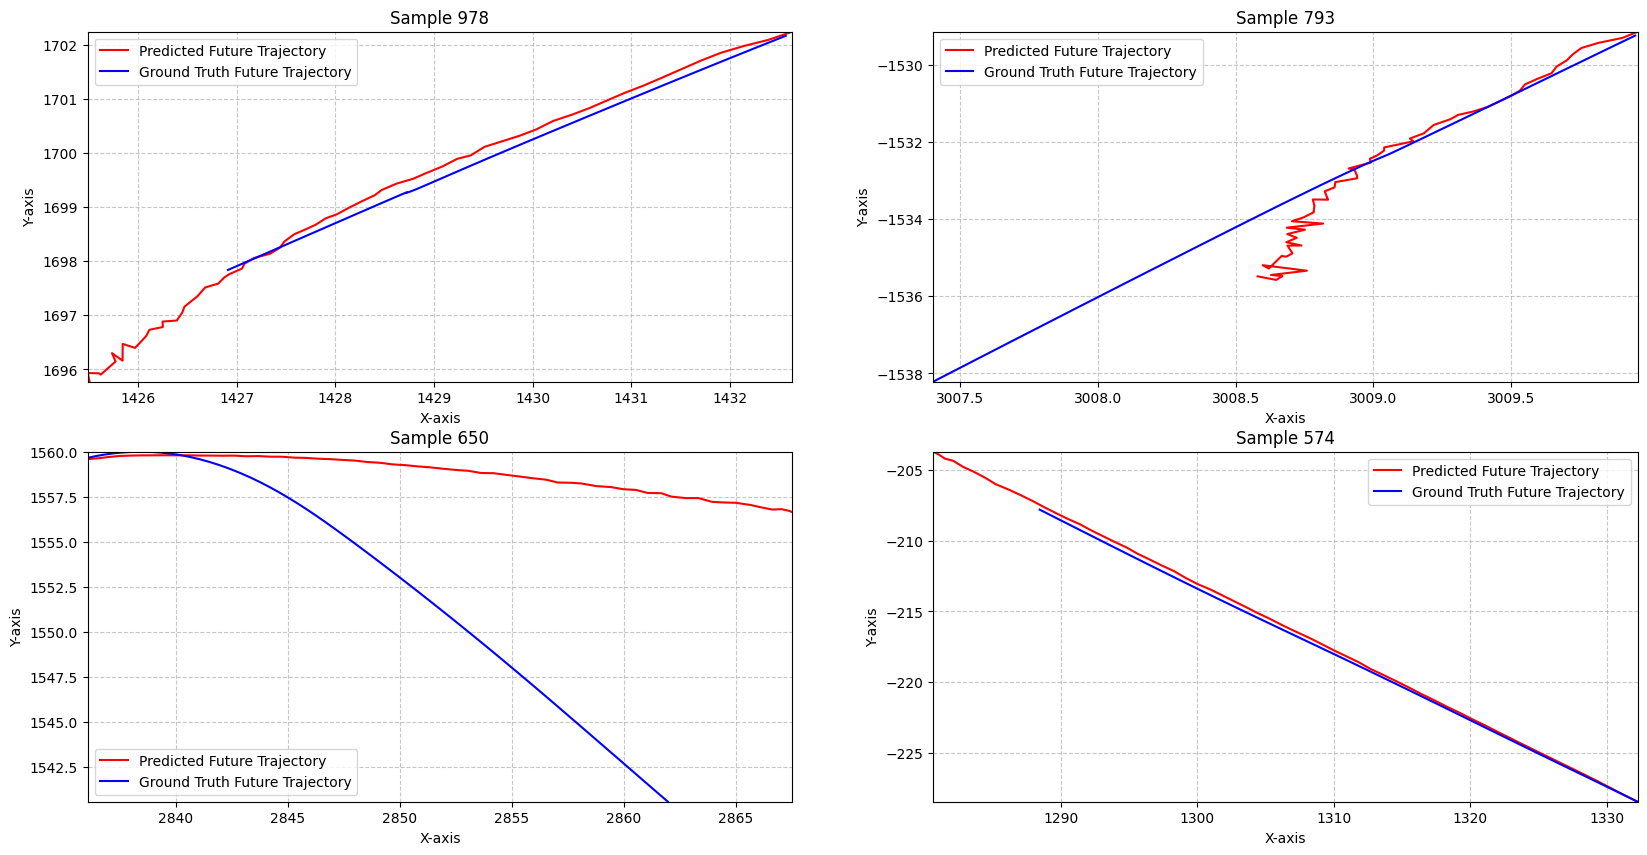

In [15]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [16]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTM().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)

        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape in __getitem__: (7, 50, 6)
hist shape i

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B